# Data Analysis of ecommerce data

### About the dataset
Kaggle location: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store
Thanks to REES46 Marketing Platform for this dataset.


The data we are analyzing contains behavior data for 7 months (from October 2019 to April 2020) from a large multi-category online store. Each row in the file represents an event. All events are related to products and users.

Events can be:

- view - a user viewed a product
- cart - a user added a product to shopping cart
- remove_from_cart - a user removed a product from shopping cart
- purchase - a user purchased a product

A session can have multiple purchase events.

A session shouldn't have more than one unique user, although there are some sessions that have two or more users. We handle this problem later in the notebook.

The revenue is given in USA, the country where the shop is located in a specific country in Middle East.

The dataset was first imported into an SQL database from which it is being queried as needed. The dataset size in SQL is 52.8 GB (as a CSV it is 52.6 GB). The data could have been normalized, but we need to query the almost the full data set and for this exploratory phase it was not needed.

### Structure of this notebook:
- Data import and preparation
- Exploratory data analysis

Some questions to answer: 
- How is the revenue spread between returning buyers
- What are the buying habits for the highest grossing 10% of buyers
- Can we approximate CLV (Customer Lifetime Value) and Customer Churn, in order to approximate acceptable levels of Customer Acquisition Cost

#### About the environment
If you want to clone this notebook, run it on Python 3.7, because the mysql.connector library has problems with Python 3.8 and higher. Otherwise use SQLAlchemy.


## Data import

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib
import matplotlib.pyplot as plt
import mysql.connector
import locale
import mycredentials #locally stored credentials for the mysql server connection, under gitignore, do not do on a shared sever, it will load credentials along with main

In [2]:
# Initialize mysql connection
mydb = mysql.connector.connect(
    host=mycredentials.host1,
    user=mycredentials.username,
    passwd=mycredentials.password,
    database=mycredentials.database
)

# Initialize cursor
mycursor = mydb.cursor()

We are now querying the all of the data where the event_type is purchase. 

In [3]:
# Fetch the data
# Since we are querying of 52.8 GB the query takes a while, be sure to set it so that it  doesn't time-out.
table_list = ['oct_2019', 'nov_2019', 'dec_2019', 'jan_2020', 'feb_2020', 'mar_2020', 'apr_2020']
#table_list = ['oct_2019', 'nov_2019']
frames = []

for table_name in table_list:
    sql = "SELECT event_time, price, user_id, user_session FROM " + table_name + " WHERE event_type = 'purchase'"
    print(sql)
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    frames.extend(myresult)

SELECT event_time, price, user_id, user_session FROM oct_2019 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM nov_2019 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM dec_2019 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM jan_2020 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM feb_2020 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM mar_2020 WHERE event_type = 'purchase'
SELECT event_time, price, user_id, user_session FROM apr_2020 WHERE event_type = 'purchase'


In [4]:
# Read the data into a pandas dataframe
data = pd.DataFrame(frames)
data.columns = ['event_time', 'price', 'user_id', 'user_session']
data.head()

,event_time,price,user_id,user_session
0,2019-10-01 00:02:14 UTC,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37 UTC,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:06:02 UTC,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
3,2019-10-01 00:07:07 UTC,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
4,2019-10-01 00:09:26 UTC,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [5]:
# Transform time column: remove time zone
data['event_time']=pd.to_datetime(data['event_time']).dt.tz_convert(None)

In [6]:
# Check to see if successful
data.head()

,event_time,price,user_id,user_session
0,2019-10-01 00:02:14,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:06:02,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
3,2019-10-01 00:07:07,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
4,2019-10-01 00:09:26,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848824 entries, 0 to 6848823
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   event_time    datetime64[ns]
 1   price         float64       
 2   user_id       int64         
 3   user_session  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 209.0+ MB


The data was correctly imported.

## Preparing the data

First we want to group purchases per session into
-> one session, multiple purchases.
With this we also want the data about the total value of purchases, the unique user that made them and the quantity of orders.

- we could also take the total number of products bought but decided not to take it

We also need to be aware that although one session should have only one unique user, there are some sessions that have more than one. In order to rectify this, we are grouping by session and user id at once.
We could have dropped this data, but grouping it this way allows:
1. the sessions with only one user to stay the same, one unique session has one unique user
2. the sessions with more than one user now have a unique realtionship via unique session + user
    - in SQL, this is the way that the primary key would be assigned for this table/dataframe

In [8]:
g_data = data.groupby(by=['user_session', 'user_id']).agg\
                                                    (Date_order=('event_time',lambda x: x.min()),# Return time of session start
                                                    user_id=('user_id',lambda x: x.unique()),# Return unique user_id
                                                    Quantity=('user_session','count'),# How many products were sold per session
                                                    money_spent=('price','sum'))\
                                                        .reset_index(drop=True)

In [9]:
# Check the newly aggregated table
g_data.head()

,Date_order,user_id,Quantity,money_spent
0,2020-04-27 07:18:28,514665829,1,422.12
1,2020-04-29 15:40:55,521230451,1,205.67
2,2020-04-16 15:39:34,563939005,1,175.81
3,2020-04-18 19:37:11,643633435,1,146.46
4,2019-10-06 11:34:30,546521725,1,289.52


In [10]:
# Check the table info
g_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5449938 entries, 0 to 5449937
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date_order   datetime64[ns]
 1   user_id      int64         
 2   Quantity     int64         
 3   money_spent  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 166.3 MB


We also need a table/dataframe with orders, unique customers, products and revenue per month

In [11]:
# Grouping by month and taking count of orders, count of unique customers, sum of products sold
ord_cust_prod_per_month = g_data.groupby(g_data["Date_order"].dt.strftime('%Y-%m')).agg(orders=('Quantity','count'),
                                                                                   customers = ('user_id', 'nunique'),
                                                                                    product_sold=('Quantity','sum'),
                                                                                       revenue = ('money_spent', 'sum'))

In [12]:
ord_cust_prod_per_month.head(10)

,orders,customers,product_sold,revenue
Date_order,,,,
2019-10,629560,347118,743189,2.300759e+08
2019-11,773198,441636,918932,2.757748e+08
2019-12,969981,500995,1162488,3.443525e+08
2020-01,690379,358868,834827,2.609813e+08
2020-02,752177,391323,1198335,3.805867e+08
2020-03,848872,453317,1024809,3.213100e+08
2020-04,785771,484965,966244,2.443661e+08


We want also want to find the first time and the last time a customer bought something, how many times they bought, and how much revenue they generated.

In [13]:
# Grouping by user_id and taking first and last purchase, number of times they bought, total revenue they generated

customer_first_last_purchase = g_data.groupby(by=['user_id']).agg(First_order=('Date_order',lambda x: x.min()),
                                                                  Last_order=('Date_order',lambda x: x.max()),
                                                                 Num_of_purchases = ('Quantity','count'),
                                                                 Revenue_per_c = ('money_spent', 'sum'))


In [14]:
customer_first_last_purchase.head()

,First_order,Last_order,Num_of_purchases,Revenue_per_c
user_id,,,,
96369466,2020-04-19 16:18:17,2020-04-19 16:18:17,1,50.71
101875240,2020-01-16 18:18:22,2020-01-16 18:18:22,1,184.52
107620212,2020-01-30 15:10:12,2020-01-30 15:10:12,1,244.28
128029678,2020-03-20 18:56:58,2020-04-08 06:52:48,2,569.89
128968633,2019-12-31 10:09:41,2020-03-07 06:28:56,4,714.01


To this table we also want to add a time delta column representing the time between the last and first purchase, which will also allow us to calculate the frequency in days.

In [15]:
customer_first_last_purchase['Time_delta']= customer_first_last_purchase['Last_order'] - customer_first_last_purchase['First_order']

In [16]:
customer_first_last_purchase.head()

,First_order,Last_order,Num_of_purchases,Revenue_per_c,Time_delta
user_id,,,,,
96369466,2020-04-19 16:18:17,2020-04-19 16:18:17,1,50.71,0 days 00:00:00
101875240,2020-01-16 18:18:22,2020-01-16 18:18:22,1,184.52,0 days 00:00:00
107620212,2020-01-30 15:10:12,2020-01-30 15:10:12,1,244.28,0 days 00:00:00
128029678,2020-03-20 18:56:58,2020-04-08 06:52:48,2,569.89,18 days 11:55:50
128968633,2019-12-31 10:09:41,2020-03-07 06:28:56,4,714.01,66 days 20:19:15


In [17]:
customer_first_last_purchase['Frequency'] = customer_first_last_purchase['Time_delta']/customer_first_last_purchase['Num_of_purchases']

In [18]:
customer_first_last_purchase.head()

,First_order,Last_order,Num_of_purchases,Revenue_per_c,Time_delta,Frequency
user_id,,,,,,
96369466,2020-04-19 16:18:17,2020-04-19 16:18:17,1,50.71,0 days 00:00:00,0 days 00:00:00
101875240,2020-01-16 18:18:22,2020-01-16 18:18:22,1,184.52,0 days 00:00:00,0 days 00:00:00
107620212,2020-01-30 15:10:12,2020-01-30 15:10:12,1,244.28,0 days 00:00:00,0 days 00:00:00
128029678,2020-03-20 18:56:58,2020-04-08 06:52:48,2,569.89,18 days 11:55:50,9 days 05:57:55
128968633,2019-12-31 10:09:41,2020-03-07 06:28:56,4,714.01,66 days 20:19:15,16 days 17:04:48.750000


Now we also want to see how many customers are entering per month and how many are never returning again. The seven month period is probably too short to make a proper analysis, but we can try it in this exploratory stage.
We start by creating two new tables grouped by First_order and Last Order.

In [19]:
# Per month: new customers, never again seen customers
new_customers = customer_first_last_purchase.groupby(customer_first_last_purchase["First_order"].dt.strftime('%Y-%m')).agg(New_customers = ("First_order", 'count'))
never_again_seen_customers = customer_first_last_purchase.groupby(customer_first_last_purchase["Last_order"].dt.strftime('%Y-%m')).agg(Last_seen_customers = ("First_order", 'count'))

We join them together.

In [20]:
# As no join on value was assigned, join is performed on index, and the index is the month
new_and_last_seen_customers = new_customers.join(never_again_seen_customers['Last_seen_customers'])

In [21]:
new_and_last_seen_customers.head(7)

,New_customers,Last_seen_customers
First_order,,
2019-10,347118,181402
2019-11,350352,249028
2019-12,347286,306469
2020-01,215886,217812
2020-02,225048,260031
2020-03,258674,365192
2020-04,320535,484965


We can now plot this data

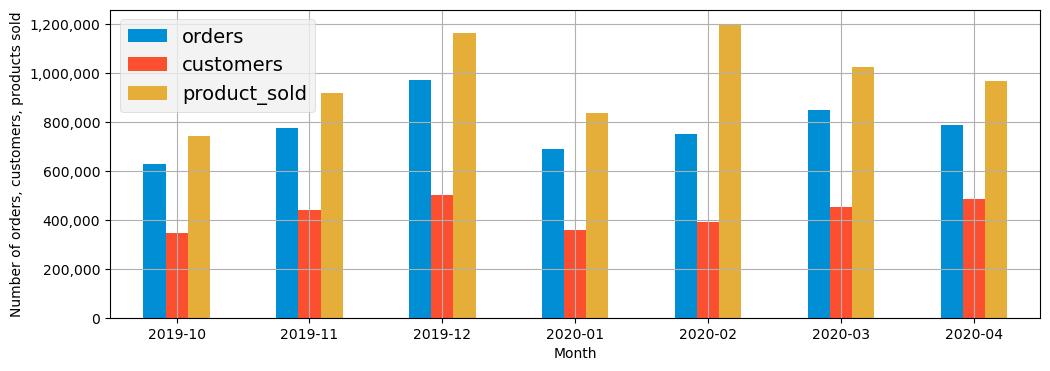

In [22]:
fig, axs = plt.subplots(figsize=(12, 4))
plt.style.use('fivethirtyeight')
ord_cust_prod_per_month.drop('revenue', axis = 1).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Number of orders, customers, products sold");  # custom x label using matplotlib
axs.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

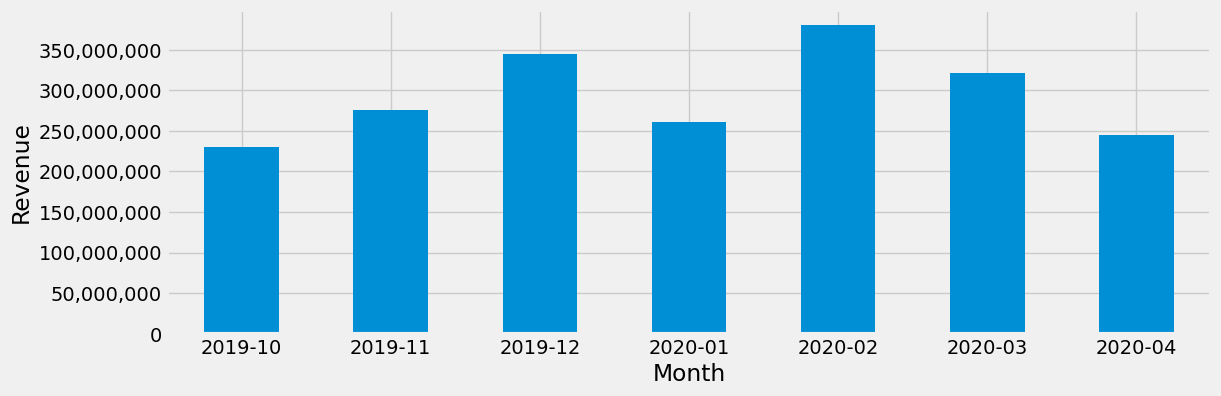

In [23]:
fig, axs = plt.subplots(figsize=(12, 4))
plt.style.use('fivethirtyeight')
ord_cust_prod_per_month['revenue'].plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Revenue");

axs.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

Who would have expected that Feb 2020 would be higher grossing than Dec 2019.

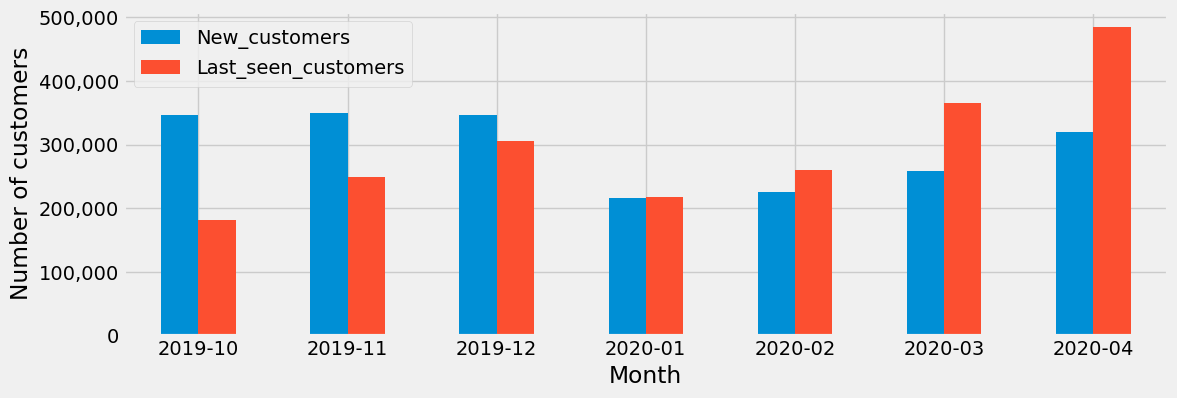

In [24]:
#New customers
#Never again seen customers
fig, axs = plt.subplots(figsize=(12, 4))
plt.style.use('fivethirtyeight')
new_and_last_seen_customers.plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Number of customers");

axs.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

Plotting aggregate data is not raising interesting questions, we need to switch to another angle.

# Customers analysis

Here we are starting to analyze the spread of revenue between customers.

In order to do that we create a new dataframe with sum of products bought and total revenue, per customer.

In [25]:
revenue_per_customer = g_data.groupby(g_data["user_id"]).agg(products_bought=('Quantity','sum'), 
                                                         total_spent = ('money_spent', 'sum'))

In [26]:
revenue_per_customer.head()

,products_bought,total_spent
user_id,,
96369466,1,50.71
101875240,1,184.52
107620212,1,244.28
128029678,3,569.89
128968633,4,714.01


We can see the distribution by taking percentiles of revenue.

In [27]:
revenue_per_customer.describe(percentiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, .25, .5, .75, .85, .95, .98])


,products_bought,total_spent
count,2.064899e+06,2.064899e+06
mean,3.316784e+00,9.963912e+02
std,8.143284e+00,3.678657e+03
min,1.000000e+00,3.100000e-01
1%,1.000000e+00,1.001000e+01
2%,1.000000e+00,1.544000e+01
3%,1.000000e+00,2.238000e+01
4%,1.000000e+00,2.700000e+01
5%,1.000000e+00,3.083000e+01
10%,1.000000e+00,5.148000e+01


Minimum that was bought in the period is :
MAximum is:

There is a huge difference and Pareto is probably in.

Let's order the table in order to make a cumulative sum.

In [28]:
revenue_per_customer = revenue_per_customer.sort_values(by = 'total_spent')

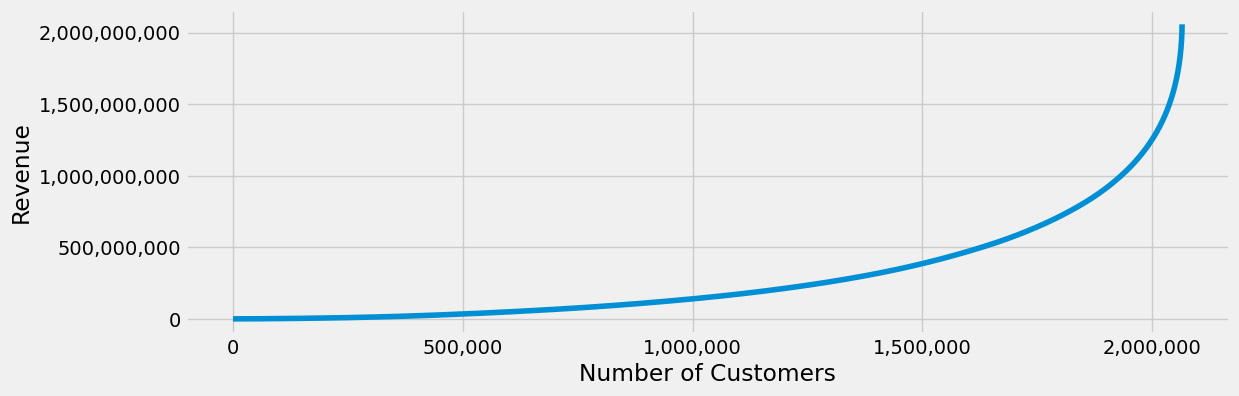

In [29]:
fig, axs = plt.subplots(figsize=(12, 4))

revenue_per_customer['total_spent'].reset_index(drop = True).cumsum().plot()

axs.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Number of Customers");  # custom x label using matplotlib
plt.ylabel("Revenue");  # custom x label using matplotlib
plt.show()

Less than 10% of the customers are making more than 50% of the revenue. This needs to be explored in more depth.

In the customer_first_last_purchase we had revenue and frequency, let's take that dataframe.

In [30]:
#customer_first_last_purchase.head()
customer_first_last_purchase[['Revenue_per_c', 'Frequency', 'Num_of_purchases']].describe(percentiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, .25, .5, .75, .85, .95, .98, 0.985, 0.99, 0.995])

,Revenue_per_c,Frequency,Num_of_purchases
count,2.064899e+06,2064899,2.064899e+06
mean,9.963912e+02,6 days 03:30:54.165226528,2.639324e+00
std,3.678657e+03,12 days 22:24:46.153293392,5.222499e+00
min,3.100000e-01,0 days 00:00:00,1.000000e+00
1%,1.001000e+01,0 days 00:00:00,1.000000e+00
2%,1.544000e+01,0 days 00:00:00,1.000000e+00
3%,2.238000e+01,0 days 00:00:00,1.000000e+00
4%,2.700000e+01,0 days 00:00:00,1.000000e+00
5%,3.083000e+01,0 days 00:00:00,1.000000e+00
10%,5.148000e+01,0 days 00:00:00,1.000000e+00


The difference between returning buyers and one time buyers is huge. We want to see how much the returning buyers that bought more than 2 times are in the population and how much they are doing revenue wise.

In [31]:
print('Number of unique buyers: {} \n\
Number of returning buyers: {} \n\
Revenue from one time buyers: {} \n\
Revenue total: {} \n\
Revenue from two time buyers: {} \n\
Number of two time buyers: {} \n\
Revenue from buyers that bought more than two times: {} \n\
'
    .format(f"{len(customer_first_last_purchase):,}",
            f"{len(customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases']>1]):,}",
            f"{customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases']==1]['Revenue_per_c'].sum():,}",
          f"{customer_first_last_purchase['Revenue_per_c'].sum():,}",
           f"{customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases'] == 2]['Revenue_per_c'].sum():,}",
           f"{customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases'] == 2]['Revenue_per_c'].count():,}",
           f"{customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases'] > 2]['Revenue_per_c'].sum():,}"))

Number of unique buyers: 2,064,899 
Number of returning buyers: 934,121 
Revenue from one time buyers: 361,184,402.21999985 
Revenue total: 2,057,447,227.859999 
Revenue from two time buyers: 256,015,156.65000004 
Number of two time buyers: 400,638 
Revenue from buyers that bought more than two times: 1,440,247,668.9899995 



We want to analyze the returning buyers. For that we need a new dataframe/table.

In [32]:
df_returning_buyers = customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases']>1]

In [33]:
df_returning_buyers.head()

,First_order,Last_order,Num_of_purchases,Revenue_per_c,Time_delta,Frequency
user_id,,,,,,
128029678,2020-03-20 18:56:58,2020-04-08 06:52:48,2,569.89,18 days 11:55:50,9 days 05:57:55
128968633,2019-12-31 10:09:41,2020-03-07 06:28:56,4,714.01,66 days 20:19:15,16 days 17:04:48.750000
145611266,2019-12-24 05:09:33,2020-04-14 16:06:11,2,81.56,112 days 10:56:38,56 days 05:28:19
171409616,2020-02-22 08:04:24,2020-04-23 04:39:40,5,316.41,60 days 20:35:16,12 days 04:07:03.200000
192078182,2020-01-17 12:51:40,2020-03-11 05:47:37,2,419.58,53 days 16:55:57,26 days 20:27:58.500000


In [34]:
df_returning_buyers.describe(percentiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, .25, .5, .75, .85, .95, .98])

,Num_of_purchases,Revenue_per_c,Time_delta,Frequency
count,934121.000000,934121.000000,934121,934121
mean,4.623769,1815.891973,49 days 18:18:11.269172837,13 days 14:05:09.177421440
std,7.286964,5336.592013,52 days 21:04:36.508890978,16 days 09:24:21.985240507
min,2.000000,1.580000,0 days 00:00:00,0 days 00:00:00
1%,2.000000,36.282000,0 days 00:05:25,0 days 00:02:39
2%,2.000000,54.060000,0 days 00:09:02,0 days 00:04:22
3%,2.000000,67.210000,0 days 00:13:49,0 days 00:06:35
4%,2.000000,79.700000,0 days 00:20:37.800000,0 days 00:09:39.500000
5%,2.000000,91.330000,0 days 00:30:54,0 days 00:14:14.500000
10%,2.000000,154.450000,0 days 05:09:30,0 days 02:11:33.200000


Possibly even those that have at least 3 purchases.

In [35]:
df_min_3_purchases = customer_first_last_purchase[customer_first_last_purchase['Num_of_purchases']>2]

In [36]:
df_min_3_purchases.describe(percentiles = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, .25, .5, .75, .85, .95, .98])

,Num_of_purchases,Revenue_per_c,Time_delta,Frequency
count,533483.000000,533483.000000,533483,533483
mean,6.594182,2699.706774,66 days 04:54:35.400344525,13 days 07:49:22.208725663
std,9.161042,6901.941376,55 days 05:23:35.510741663,12 days 21:33:08.101300754
min,3.000000,2.490000,0 days 00:00:30,0 days 00:00:10
1%,3.000000,74.440000,0 days 00:51:24.819999999,0 days 00:15:36.954999999
2%,3.000000,105.250000,0 days 02:50:15.839999999,0 days 00:49:50.346666666
3%,3.000000,130.500000,0 days 07:57:03.839999999,0 days 02:11:27.773000
4%,3.000000,154.220000,0 days 16:41:01.119999999,0 days 04:18:30.666666666
5%,3.000000,176.730000,0 days 22:17:23.200000,0 days 06:00:25.775000
10%,3.000000,281.202000,3 days 03:30:18.200000,0 days 17:48:40.346666666


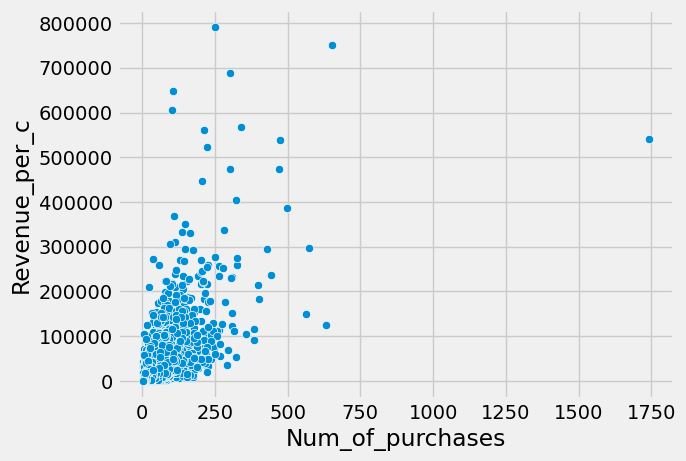

In [37]:
sns.scatterplot(data=df_min_3_purchases, x="Num_of_purchases", y="Revenue_per_c")
plt.show()

To be honest, from a user perspective, someone who is buying up to 10.000$ per year can be a private user, all the others are either B2B (big client or reseller).

Let's split the total population of customers into bins per percentiles and see if we get some more insight.

# Using qcut

The pandas documentation describes qcut as a “Quantile-based discretization function.” This basically means that qcut tries to divide up the underlying data into equal sized bins.

We will be doing it once for revenue and once for number of purchases. First the revenue.

In [38]:
customer_first_last_purchase['Pop50Revenue'] = pd.qcut(customer_first_last_purchase['Revenue_per_c'], q = 50)

In [39]:
customer_first_last_purchase.head()

,First_order,Last_order,Num_of_purchases,Revenue_per_c,Time_delta,Frequency,Pop50Revenue
user_id,,,,,,,
96369466,2020-04-19 16:18:17,2020-04-19 16:18:17,1,50.71,0 days 00:00:00,0 days 00:00:00,"(43.48, 51.48]"
101875240,2020-01-16 18:18:22,2020-01-16 18:18:22,1,184.52,0 days 00:00:00,0 days 00:00:00,"(177.564, 189.403]"
107620212,2020-01-30 15:10:12,2020-01-30 15:10:12,1,244.28,0 days 00:00:00,0 days 00:00:00,"(232.72, 249.86]"
128029678,2020-03-20 18:56:58,2020-04-08 06:52:48,2,569.89,18 days 11:55:50,9 days 05:57:55,"(534.57, 579.02]"
128968633,2019-12-31 10:09:41,2020-03-07 06:28:56,4,714.01,66 days 20:19:15,16 days 17:04:48.750000,"(693.456, 755.1]"


And now we aggregate it in order to be able to plot it.

In [40]:
df_pop_50_revenue = customer_first_last_purchase.groupby(by=['Pop50Revenue']).agg(revenue_per_pop=('Revenue_per_c', 'sum'))

A pandas series is a result of this operation, so we need to transform to a dataframe and reset index in order to plot it with seaborn.

In [41]:
df_pop_50_revenue = pd.DataFrame(df_pop_50_revenue).reset_index()


In [42]:
df_pop_50_revenue.head(50)

,Pop50Revenue,revenue_per_pop
0,"(0.309, 15.44]",4.077309e+05
1,"(15.44, 27.0]",9.129018e+05
2,"(27.0, 34.98]",1.267509e+06
3,"(34.98, 43.48]",1.619324e+06
4,"(43.48, 51.48]",2.002938e+06
5,"(51.48, 62.96]",2.344685e+06
6,"(62.96, 74.62]",2.860074e+06
7,"(74.62, 87.46]",3.291426e+06
8,"(87.46, 101.116]",3.873146e+06
9,"(101.116, 114.01]",4.419500e+06


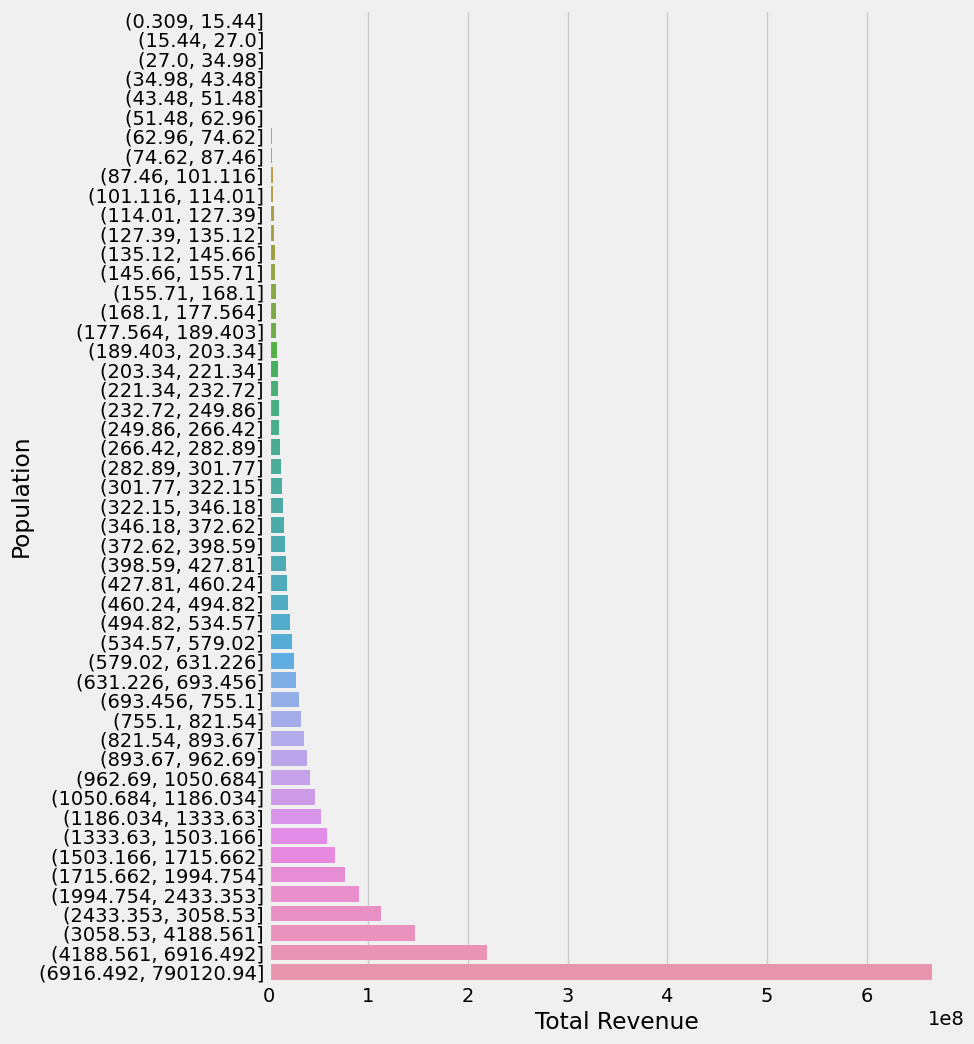

In [43]:
plt.figure(figsize=(8,12))
ax = sns.barplot(x="revenue_per_pop", y="Pop50Revenue", data=df_pop_50_revenue)
ax.set(xlabel='Total Revenue', ylabel='Population')
plt.show()

The spread between the last 'bin' and the next one is staggering. The highest grossing 2% of the buyers are making almost a third of the revenue.  In future we will need to analyze what these customers are buying.

We do the same analysis for the number of purchases, to see if the highest grossing customers are actually buying more frequently, or buying higher value products.

In [44]:
df_pop_50_purchases = customer_first_last_purchase.groupby(by=['Pop50Revenue']).\
agg(revenue_per_pop=('Num_of_purchases', 'sum')).reset_index()

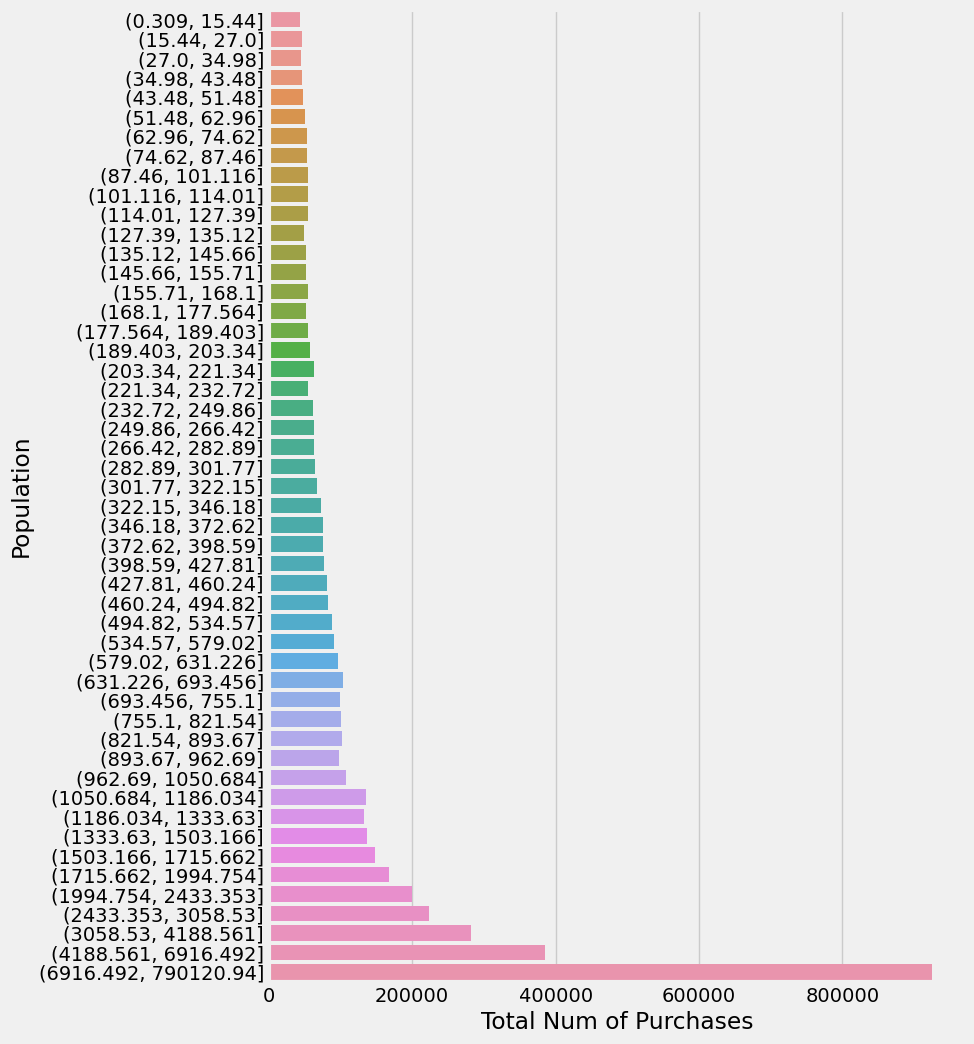

In [45]:
plt.figure(figsize=(8,12))
ax = sns.barplot(x="revenue_per_pop", y="Pop50Revenue", data=df_pop_50_purchases)
ax.set(xlabel='Total Num of Purchases', ylabel='Population')
plt.show()

They are actually buying more frequently.

Next step is to see what they are actually buying.